# ANALYZING MUSIC MARKET

In this project, we will analyze the music market by using chinook database. We will try to answer some business questions about music market. We will use SQL queries to manage the relational database. Let's start with opening data.

### Opening Data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
db= 'chinook.db'

Now, we need some functions to open, use and manage the  database on our study.

In [3]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
    

In [4]:
def run_command(c):
    with sqlite.connect(db) as conn:
        conn.isolation_level= None
        conn.execute(c)

In [5]:
def show_tables():
    q= """ SELECT name, type FROM sqlite_master WHERE type IN ("table","view");"""
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


We have 11 tables which are related with each other. We will write a query that returns all genres of albums. And it will contain number of tacks and number of sold for each genre in USA.

### Observing Genres of Albums

In [7]:
albums_to_purchase_usa="""
WITH usa_tracks_sold AS
(SELECT il.* FROM invoice_line il INNER JOIN invoice i on il.invoice_id= i.invoice_id
INNER JOIN customer c on i.customer_id= c.customer_id WHERE c.country= "USA")
SELECT g.name genre, count(uts.invoice_line_id) tracks_sold,
cast(count(uts.invoice_line_id) AS FLOAT)/ (SELECT COUNT(*) from usa_tracks_sold)percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id= t.genre_id
GROUP BY 1 ORDER BY 2 DESC LIMIT 10;"""


run_query(albums_to_purchase_usa)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


We have 10 types of genre. We can visualize it to understand easly.

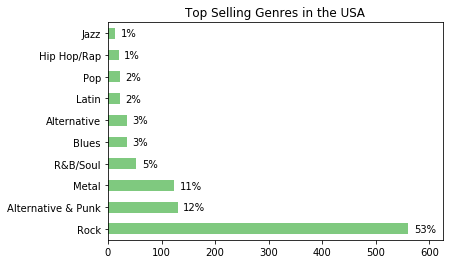

In [8]:
genre_sales_usa= run_query(albums_to_purchase_usa)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh( title="Top Selling Genres in the USA", xlim=(0,625), colormap=plt.cm.Accent)
plt.ylabel("")

for i,label in enumerate(list(genre_sales_usa.index)):
    score= genre_sales_usa.loc[label, "tracks_sold"]
    label= (genre_sales_usa.loc[label, "percentage_sold"]* 100).astype(int).astype(str)+ "%"
    plt.annotate(str(label), (score+10, i-0.15))
    
plt.show()

This graphic shows the percentage of sold of each genre. The "Rock" albums is sold most than other albums. It has 53% interest in music market in USA. 

Let's take a look to situation for Czech Republic.

In [9]:
albums_to_purchase_czech="""
WITH usa_tracks_sold AS
(SELECT il.* FROM invoice_line il INNER JOIN invoice i on il.invoice_id= i.invoice_id
INNER JOIN customer c on i.customer_id= c.customer_id WHERE c.country= "Czech Republic")
SELECT g.name genre, count(uts.invoice_line_id) tracks_sold,
cast(count(uts.invoice_line_id) AS FLOAT)/ (SELECT COUNT(*) from usa_tracks_sold)percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id= t.genre_id
GROUP BY 1 ORDER BY 2 DESC LIMIT 10;"""


run_query(albums_to_purchase_czech)

,genre,tracks_sold,percentage_sold
0,Rock,143,0.518116
1,Alternative & Punk,42,0.152174
2,Metal,23,0.083333
3,Latin,21,0.076087
4,Blues,18,0.065217
5,Alternative,10,0.036232
6,R&B/Soul,5,0.018116
7,Classical,3,0.010870
8,Easy Listening,3,0.010870
9,Jazz,3,0.010870


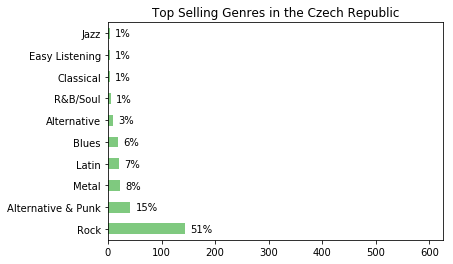

In [10]:
genre_sales_czech= run_query(albums_to_purchase_czech)
genre_sales_czech.set_index("genre", inplace=True, drop=True)

genre_sales_czech["tracks_sold"].plot.barh( title="Top Selling Genres in the Czech Republic", xlim=(0,625), colormap=plt.cm.Accent)
plt.ylabel("")

for i,label in enumerate(list(genre_sales_czech.index)):
    score= genre_sales_czech.loc[label, "tracks_sold"]
    label= (genre_sales_czech.loc[label, "percentage_sold"]* 100).astype(int).astype(str)+ "%"
    plt.annotate(str(label), (score+10, i-0.15))
    
plt.show()

The "Rock" albums is sold most than other albums. It has 51% interest in music market in Czech Republic.

### Observing Employee Perfomance

We can create a query which return employee information. And we can observe their performance by looking theair sales amount.

In [11]:
employee_sales_performance= """ 
WITH customer_support_rep_sales AS
(SELECT i.customer_id, c.support_rep_id, SUM(i.total) total FROM invoice i
INNER JOIN customer c ON i.customer_id= c.customer_id GROUP BY 1,2)
SELECT e.first_name ||""|| e.last_name employee, e.hire_date, SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id= csrs.support_rep_id GROUP BY 1;"""

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,JanePeacock,2017-04-01 00:00:00,1731.51
1,MargaretPark,2017-05-03 00:00:00,1584.00
2,SteveJohnson,2017-10-17 00:00:00,1393.92


Let's visualize to understand easyly.

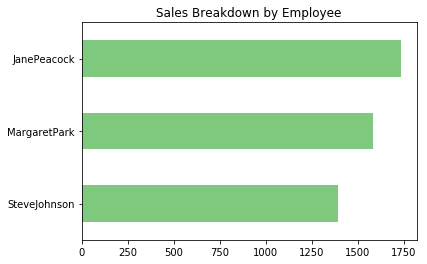

In [12]:
employee_sales= run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(legend=False, title="Sales Breakdown by Employee", colormap=plt.cm.Accent)

plt.ylabel("")
plt.show()

Jane Peacock has the highest performance. The second one is Margaret Park. And the last one is Steve Johnson.

### Sales by Country

We will use a query which returns the sales of each country.

In [13]:
sales_by_country= """
WITH country_or_other AS
(SELECT CASE WHEN ( SELECT count(*) FROM customer WHERE country= c.country)=1 THEN "Other"
ELSE c.country END AS country, c.customer_id, il.* FROM invoice_line il 
INNER JOIN invoice i ON i.invoice_id= il.invoice_id
INNER JOIN customer c ON c.customer_id= i.customer_id)
SELECT country, customers, total_sales, average_order, customer_lifetime_value
FROM
(SELECT country, count(distinct customer_id) customers, SUM(unit_price) total_sales,
SUM(unit_price)/count(distinct customer_id) customer_lifetime_value,
SUM(unit_price)/ count(distinct invoice_id) average_order,
CASE WHEN country= "Other" THEN 1 ELSE 0 END AS sort FROM country_or_other
GROUP BY country ORDER BY sort ASC, total_sales DESC);"""

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


We will visualize this table on graphic.

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


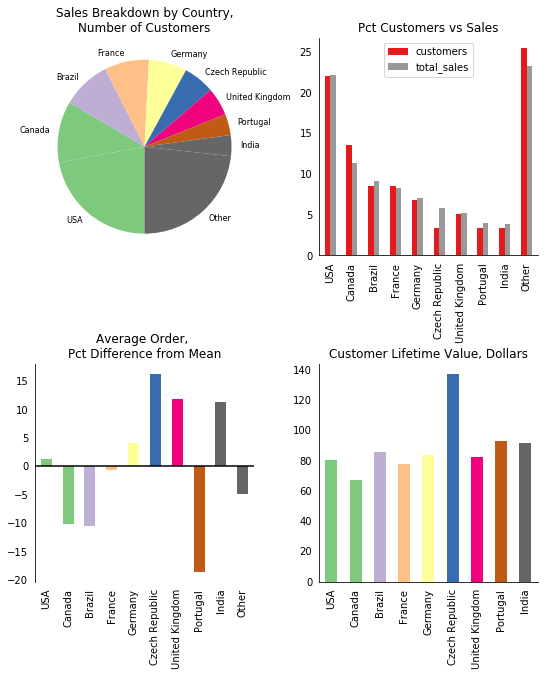

In [14]:
country_metrics= run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors= [plt.cm.Accent(i) for i in np.linspace(0,1, country_metrics.shape[0])]


fig,axes= plt.subplots(nrows=2, ncols=2, figsize=(9,10))
ax1,ax2,ax3,ax4= axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#Sales Breakdown by Country, Number of Customers
sales_breakdown= country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(
ax= ax1,
startangle=-90,
counterclock= False,
title="Sales Breakdown by Country,\nNumber of Customers",
colormap=plt.cm.Accent,
fontsize=8,
wedgeprops={"linewidth":0})

#Pct Customers vs Sales
cvd_cols= ["customers", "total_sales"]
custs_vs_dollars= country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name=""
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum()/100
custs_vs_dollars.plot.bar(ax=ax2, colormap=plt.cm.Set1, title= "Pct Customers vs Sales")
ax2.tick_params(top="off", right="off",left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#Average Order, Pct Difference from Mean
avg_order= country_metrics["average_order"].copy()
avg_order.index.name= ""
difference_from_avg= avg_order*100/ avg_order.mean()-100
difference_from_avg.plot.bar(ax=ax3, color=colors, title="Average Order, \nPct Difference from Mean")
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color="k")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#Customer Lifetime Value, Dollars
ltv= country_metrics["customer_lifetime_value"].copy()
ltv.index.name= ""
ltv.drop("Other", inplace=True)
ltv.plot.bar(ax=ax4, color=colors, title="Customer Lifetime Value, Dollars")
ax4.tick_params(top="off", left="off", right="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

The USA has more potantial than other countries to sale music albums. The average number of orders is close to mean of sales for USA. The average number of orders is close to mean of sales for France, but this average number less than the mean of the sales.

### Analyzing Album's and Individual Track's Sales  

Now, we will explore the customer's prefer. Are customers buy albums or individual tracks which they want?

In [15]:
albums_vs_tracks= """ 
WITH invoice_first_track AS 
(SELECT il.invoice_id invoice_id, MIN(il.track_id) first_track_id 
FROM invoice_line il GROUP BY 1)
SELECT album_purchase, COUNT(invoice_id) number_of_invoices, CAST(count(invoice_id) AS FLOAT)/
(SELECT COUNT(*) FROM invoice)percent
FROM (SELECT ifs.*, CASE WHEN(SELECT t.track_id FROM track t 
WHERE t.album_id=(SELECT t2.album_id FROM track t2 WHERE t2.track_id= ifs.first_track_id)
EXCEPT SELECT il2.track_id FROM invoice_line il2 WHERE il2.invoice_id=ifs.invoice_id)
IS NULL AND(
SELECT il2.track_id FROM invoice_line il2 WHERE il2.invoice_id=ifs.invoice_id
EXCEPT
SELECT t.track_id FROM track t WHERE t.album_id=(SELECT t2.album_id FROM track t2 WHERE t2.track_id= ifs.first_track_id))
IS NULL THEN "yes" ELSE "no" END AS "album_purchase" FROM invoice_first_track ifs)
GROUP BY album_purchase;"""

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


We can say that the 81% of customers prefer individual records. They do not buy albums, they buy only music records which they like. The rate of customers is 19% who buy albums.

### Summary

According to our analysis, USA has high customer market. And, the type of "Rock"  is most favorite than others in USA. And we do not have too much data from Czech Republic, but it is seen that there is a potentional customer. Czech Republic has the highest average order and customer life time. Also "Rock" types of music records are most popular, with 51%. The second type of genre is "Alternative and Punk", 15%. For deep investments, USA can be take into account. For small scale investments, Czech Republic can be a good stepping-stone.